# Use spectra of CTIO Data in January 2017 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : January 16th 2017
- update : February 11th 2017


This notebook is supposed to perform an atmospheric properties measurement on spectra




In [6]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [7]:
print theNotebook

AnaAerCalibDataSim_Spectrum_HD14943


In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [9]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [10]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [11]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.0.0


In [12]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [13]:
%load_ext Cython

In [14]:
from IPython.display import Image, display

In [15]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [16]:
from scipy.interpolate import interp1d

In [17]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [18]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [19]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [20]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (4, 4),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [21]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [22]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [23]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### Output directory for images generated in the notebook view (not true fits images)¶¶

In [24]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [25]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [26]:
inputdir="./spectrum_calibcompsimrealspec"
object_name='HD14943'

### Output Fits file

In [27]:
outputdir="./spectrum_anaaer"

In [28]:
ensure_dir(outputdir)

In [29]:
output_file='AnaAtmAerFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [30]:
input_filelist=os.listdir(inputdir) 

In [31]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [32]:
print input_filelist[0:5]

['compSimRealSpectra_HD14943_20170117_092.fits'
 'compSimRealSpectra_HD14943_20170117_093.fits'
 'compSimRealSpectra_HD14943_20170117_094.fits'
 'compSimRealSpectra_HD14943_20170117_095.fits'
 'compSimRealSpectra_HD14943_20170117_096.fits']


In [33]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [34]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file     
            if re.search('.*fits$',filename):  #example of filename filter
                num_str=re.findall('^compSimRealSpectra_HD14943_20170117_([0-9]+).fits',file)[0]
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [35]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [36]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [37]:
print indexes_files

[ 92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195]


In [38]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [39]:
sorted_numbers=indexes_files[sorted_indexes]

In [40]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103]


In [41]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [42]:
sorted_files[0:5]

array([ './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_092.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_093.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_094.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_095.fits',
       './spectrum_calibcompsimrealspec/compSimRealSpectra_HD14943_20170117_096.fits'], 
      dtype='|S76')

## Build full filename
----------------------------

In [43]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [44]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [45]:
print sorted_filenames.shape

(104,)


## Acces to spectrum data
----------------------------------

In [46]:
all_dates = []
all_airmass = []
all_spectra = []
all_titles = []
all_header = []
all_img = []

In [47]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    all_leftspectra_sim = []
    all_rightspectra_sim = []
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpecData')
        left_spectrum_sim=table_data.field('CalibLeftSpecSim')
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpecData')
        right_spectrum_sim=table_data.field('CalibRightSpecSim')
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
        all_leftspectra_sim.append(left_spectrum_sim)
        all_rightspectra_sim.append(right_spectrum_sim)
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl, \
        all_rightspectra_wl

In [48]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_sim,all_rightspectra_sim,all_leftspectra_wl,all_rightspectra_wl=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [49]:
print len(all_dates)

104


## 1.) Show Spectra
==========================

In [50]:
NDATA=len(all_rightspectra_data)

In [51]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
    
def ShowSpectra(all_spectra,all_ssim,all_wl,all_titles,object_name):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBIMAGES=len(all_spectra)
    MAXIMGROW=int(NBIMAGES/5)+1
    thex0 = []
    f, axarr = plt.subplots(MAXIMGROW,5,figsize=(25,60))
    f.tight_layout()
    #plt.subplot_tool() 
    for index in np.arange(0,NBIMAGES):
        ix=index%5
        iy=index/5
        spectrum=all_spectra[index]
        spectrumsim=all_ssim[index]
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        axarr[iy,ix].plot(wl,spectrumsim,'b-',lw=2,label='sim')
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].set_ylim(0.,3000.)
        axarr[iy,ix].set_xlim(100.,1100.)
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='k', linewidth=0.5)
      
        
    
    #title='spectra'
    #plt.suptitle(title,size=16)
   

### Work only on right spectra

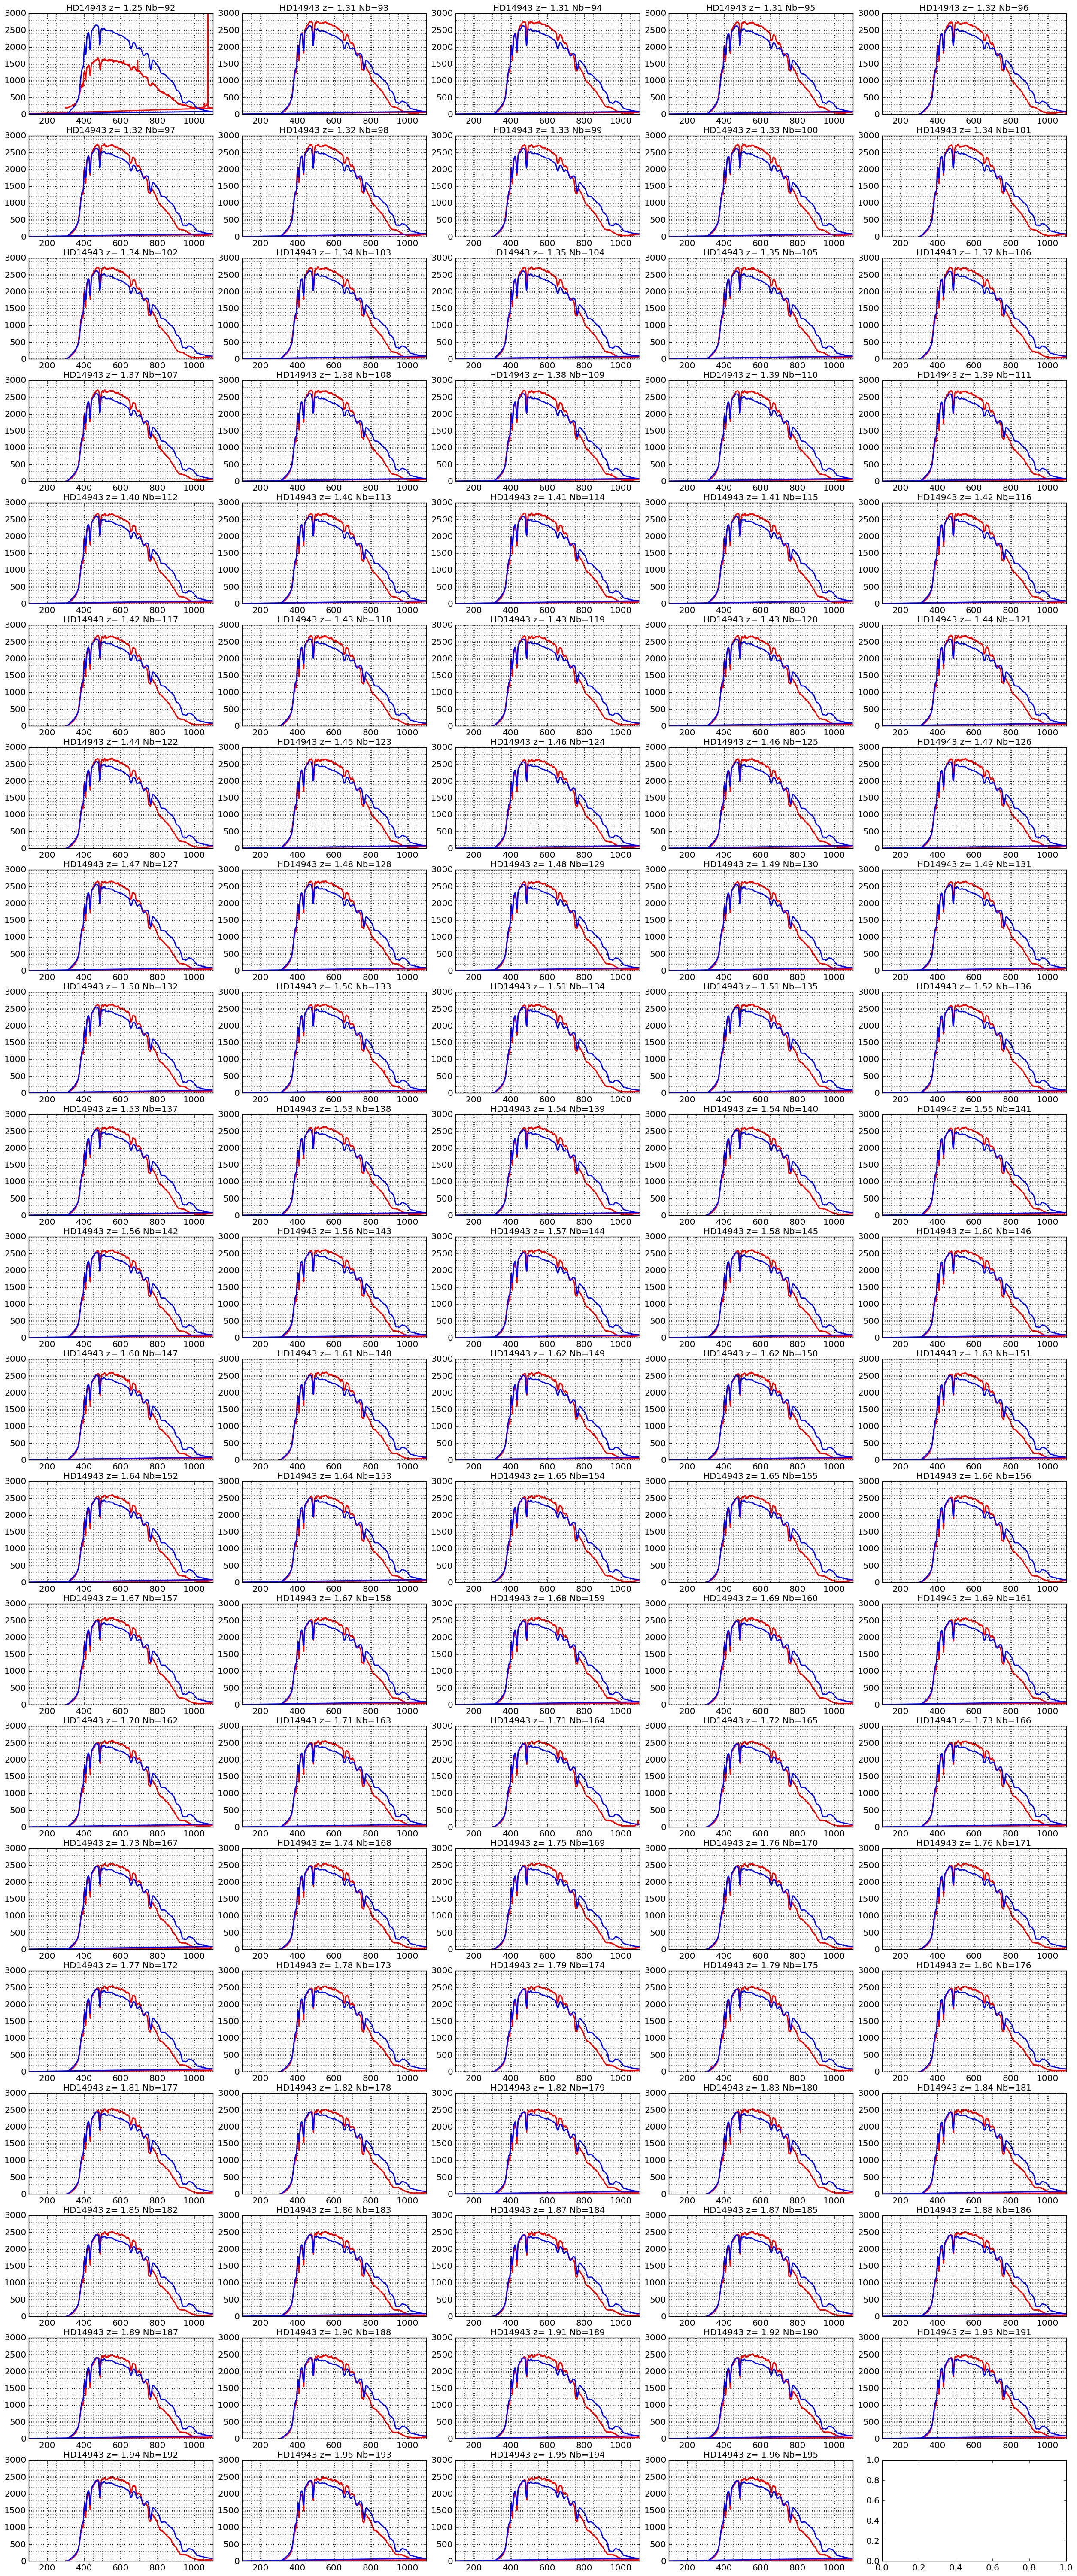

In [52]:
ShowSpectra(all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name)

In [53]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [54]:
sel=1
thespectrum=all_rightspectra_data[sel]

In [55]:
#thespectrum

In [56]:
#print all_rightspectra_data[sel]

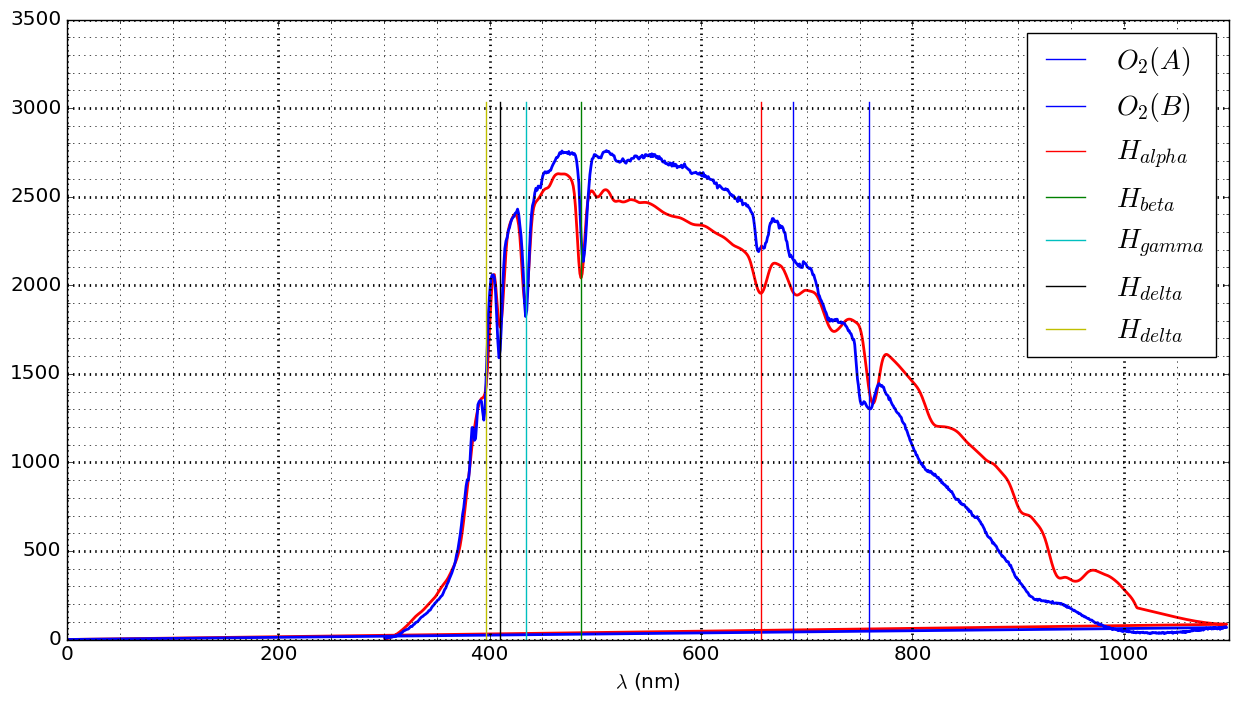

In [57]:
sel=1
thespectrum=all_rightspectra_data[sel]
thesimspectrum=all_rightspectra_sim[sel]

thewl=all_rightspectra_wl[sel]
ymin=thespectrum.min()
ymax=thespectrum.max()*1.1

fig, ax = plt.subplots(1, 1, figsize=(15,8))

ax.plot(thewl,thesimspectrum,'r-',lw=2)
ax.plot(thewl,thespectrum,'b-',lw=2)

ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)

ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

ax.legend(loc='best',fontsize=20)
ax.set_xlim(0,1100)
ax.set_xlabel("$\lambda$ (nm)")

## 2.) Study ratio Data/Sim spectra
============================================

In [58]:
def ShowRatioSpectra(thewl,thespectrum,thesimspec,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
                  
        ratio=thespectrum[index]/thesimspec[index]
        all_ymin.append(ratio.min())
        all_ymax.append(ratio.max())
        
        if(all_expo[index] >0 ):
            ax.plot(thewl[index],ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")

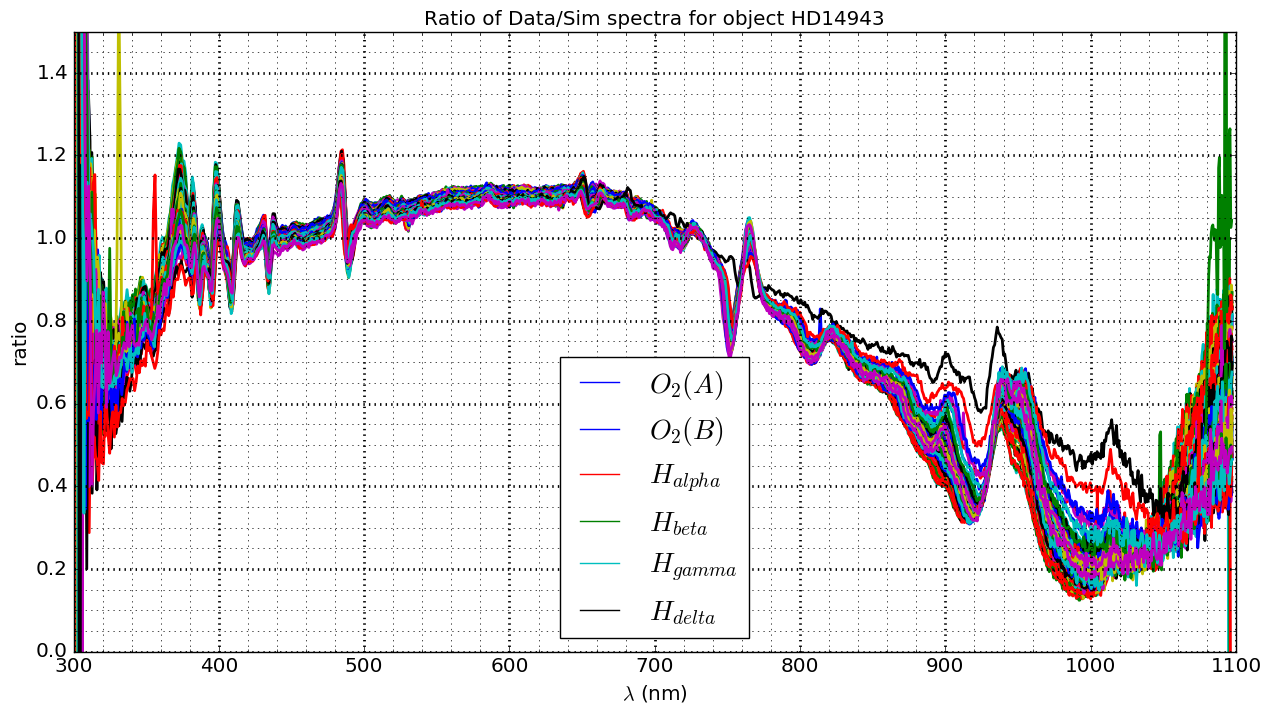

In [59]:
#all_rightspectra_data,all_rightspectra_sim,all_rightspectra_wl,all_titles,object_name
ShowRatioSpectra(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,all_titles,object_name)




## Average of Ratio Data/Sim

In [60]:
#np.where(all_rightspectra_wl[1]>wlcut)

In [61]:
wlcut=400

In [62]:
def ShowRatioSpectraSum(thewl,thespectrum,thesimspec,wlcut,all_titles,object_name):
    """
    ShowRatioSpectra: Show the camibration curve
    ==============
    """

    NBSPECTRA=len(thespectrum)

    # Plot 1) show the ratio data/Sim
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))

    all_ymin= []
    all_ymax=[]
    all_sum=[]
    
    for index in np.arange(0,NBSPECTRA):
        ix=index%5
        iy=index/5
         
        selectedindexes=np.where(all_rightspectra_wl[index]>wlcut)    
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=all_rightspectra_wl[index][selectedindexes]
        
        ratio=sel_data/sel_sim ## Compute here the ratio data/sim
        
        if(all_expo[index]>0):
            all_ymin.append(ratio.min())
            all_ymax.append(ratio.max())
            all_sum.append(ratio.mean())
                       
            ax.plot(sel_wl,ratio,'-',lw=2)
       
    ymin=np.array(all_ymin).min() 
    ymax=np.array(all_ymax).max()*1.1   
        
    #ax.set_xlim(0.,1000.)
    ax.set_ylim(0,1.5)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.legend(loc='best',fontsize=20)
    title='Ratio of Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_xlim(300.,1000.)
    
    ## plot 2 
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    plt.plot(all_sum,'ro')
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    title='Average of Ratio of Data/Sim spectra over wavelegth for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio average ")
    ax.set_xlabel(" image number")
    return np.array(all_sum)

### Ratio versus image number

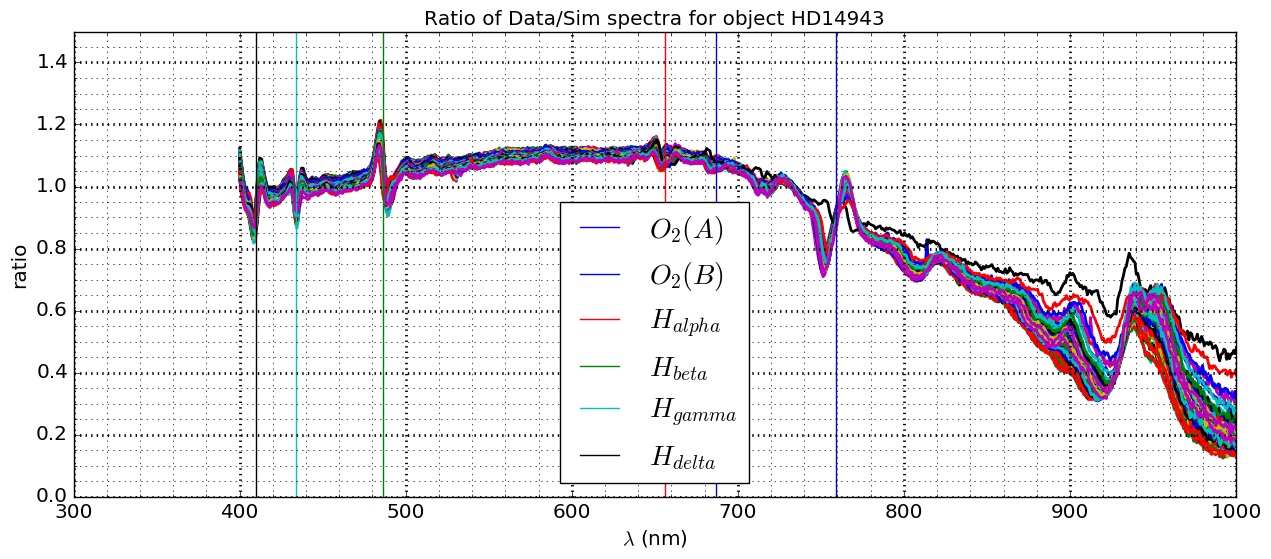

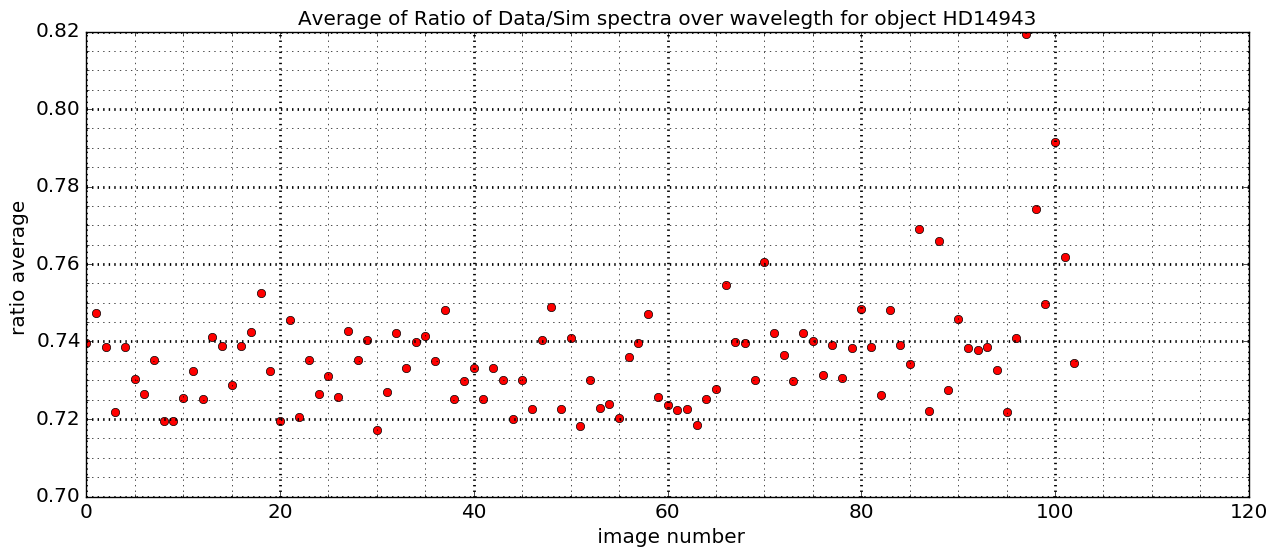

In [63]:
all_ratioaver=ShowRatioSpectraSum(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

In [64]:
np.where(all_expo==0.)

(array([], dtype=int64),)

In [65]:
print all_expo

[0.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 25.154, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 30.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0, 20.0]


In [66]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

## Here remove the crazy first image for that particular date

In [67]:
all_dt.remove(datetime.datetime(2017, 1, 18, 2, 1, 59, 245000))
NDATA-=1

In [68]:
#all_airmass

In [69]:
#all_dt

In [70]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [71]:
#am=np.array(all_airmass)*.25

### Ratio versus image date

/Users/dagoret-campagnesylvie/.local/lib/python2.7/site-packages/matplotlib/cbook.py:2644: UserWarning: Saw kwargs [u'lw', u'linewidth'] which are all aliases for u'linewidth'.  Kept value from u'linewidth'
  seen=seen, canon=canonical, used=seen[-1]))


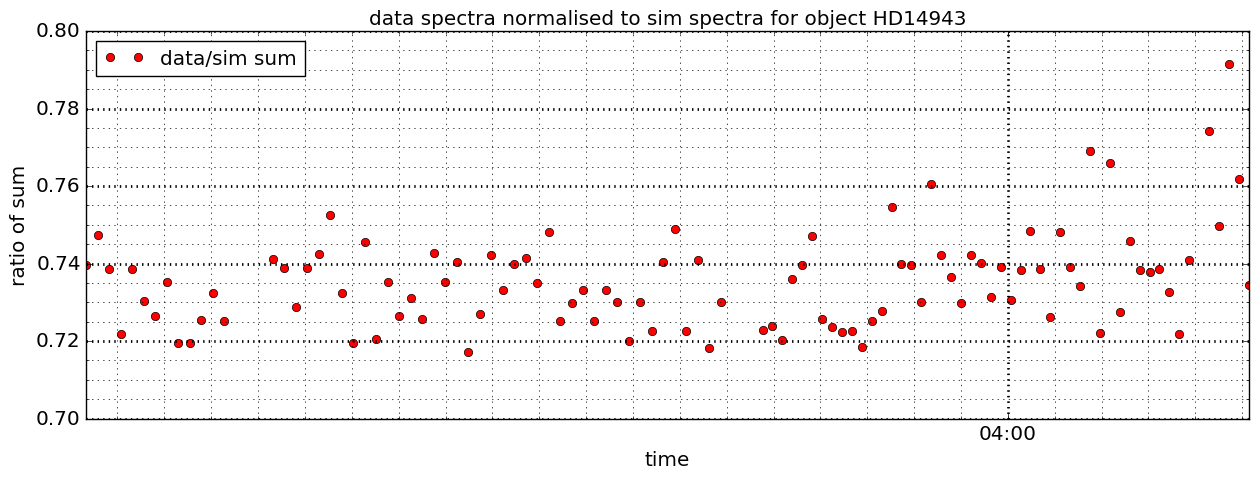

In [72]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_ratioaver,marker='o',color='red',lw=0,label='data/sim sum',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

ax.set_ylim(0.7,0.8)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='k', linewidth=0.5)
ax.set_ylabel('ratio of sum')
ax.set_xlabel('time')


title='data spectra normalised to sim spectra for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

#plt.savefig(figfilename1, bbox_inches='tight')

## 3.) Aerosols : phase 1 : (Data/Sim)(at z) / (Data/Sim)(at zmin)

In [73]:
def RemoveAbsorptionLines(thewl,thespectrum,thesimspec):
   
    
    WLMINAbs=np.array([405.,430.,480.,700,740])
    WLMAXAbs=np.array([415.,440.,500.,730,780])
    NAbsLines=WLMINAbs.shape[0]
    
    NBSPECTRA=len(thespectrum)
    
    all_selected_wl= []
    all_selected_dataspectrum= []
    all_selected_simspectrum= []
    
    for index in np.arange(0,NBSPECTRA):
        wl=np.copy(thewl[index])
        data=np.copy(thespectrum[index])
        sim=np.copy(thesimspec[index])
        
        not_selected_indexes=np.empty((0))  ### Create an empty array
               
        for iline in range(NAbsLines):     
        
            selected_to_add=np.where(np.logical_and(wl>WLMINAbs[iline],wl<WLMAXAbs[iline]))
            not_selected_indexes=np.append(not_selected_indexes,selected_to_add)

        
        all_selected_wl.append(np.delete(wl,not_selected_indexes))
        all_selected_dataspectrum.append(np.delete(data,not_selected_indexes))
        all_selected_simspectrum.append(np.delete(sim,not_selected_indexes))
        
        
    return np.array(all_selected_wl),np.array(all_selected_dataspectrum),np.array(all_selected_simspectrum) 

In [74]:
all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum=RemoveAbsorptionLines(all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim)

In [75]:
print all_selected_wl[1].shape[0]
print all_selected_dataspectrum[1].shape[0]
print all_selected_simspectrum[1].shape[0]

861
861
861


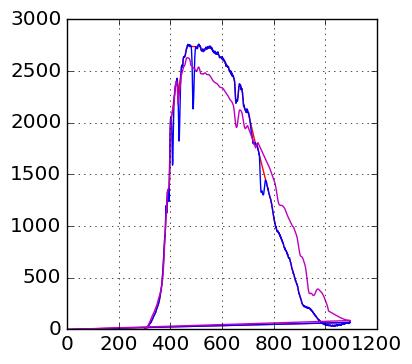

In [76]:
plt.plot(all_selected_wl[1],all_selected_dataspectrum[1],'r-')
plt.plot(all_rightspectra_wl[1],all_rightspectra_data[1],'b-')
plt.plot(all_selected_wl[1],all_selected_simspectrum[1],'m-')
plt.grid()

In [77]:
#all_airmass

## True Bouguer line on data spectrum

In [78]:
def bougline(x, a, b):
    return a*x + b

In [79]:
def ShowTrueBouguer(thewl,thespec,thezam):
    """
    ShowTrueBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBSPEC=len(thespec)
    
    all_z = []
    all_log10S1vsZ = []
    all_log10S2vsZ = []
    all_log10S3vsZ = []
    all_log10S4vsZ = []
    all_log10S5vsZ = []
    all_log10S6vsZ = []
    all_log10S1vsZE = []
    all_log10S2vsZE = []
    all_log10S3vsZE = []
    all_log10S4vsZE = []
    all_log10S5vsZE = []
    all_log10S6vsZE = []
    
    fitparam = []
    all_yfit = []   
    xfit=np.linspace(1.,2.0,50)
    all_popt = []
    all_perr = []
    
    # loop on spectra
    for index in np.arange(NBSPEC):
        
        if all_expo[index]>0.: 
        
            thez=thezam[index]
              
            wl_current=thewl[index]
            wl_spec=thespec[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_S1=wl_spec[band1]
            all_S2=wl_spec[band2]
            all_S3=wl_spec[band3]
            all_S4=wl_spec[band4]
            all_S5=wl_spec[band5]
            all_S6=wl_spec[band6]
        
            all_log10S1 = 2.5*np.log10(all_S1)
            all_log10S2 = 2.5*np.log10(all_S2)
            all_log10S3 = 2.5*np.log10(all_S3)
            all_log10S4 = 2.5*np.log10(all_S4)
            all_log10S5 = 2.5*np.log10(all_S5)
            all_log10S6 = 2.5*np.log10(all_S6)
    
            all_z.append(thez)
            all_log10S1vsZ.append(np.average(all_log10S1))
            all_log10S2vsZ.append(np.average(all_log10S2))
            all_log10S3vsZ.append(np.average(all_log10S3))
            all_log10S4vsZ.append(np.average(all_log10S4))
            all_log10S5vsZ.append(np.average(all_log10S5))
            all_log10S6vsZ.append(np.average(all_log10S6))
            all_log10S1vsZE.append(np.std(all_log10S1)/np.sqrt(all_log10S1.shape[0]))
            all_log10S2vsZE.append(np.std(all_log10S2)/np.sqrt(all_log10S2.shape[0]))
            all_log10S3vsZE.append(np.std(all_log10S3)/np.sqrt(all_log10S3.shape[0]))
            all_log10S4vsZE.append(np.std(all_log10S4)/np.sqrt(all_log10S4.shape[0]))
            all_log10S5vsZE.append(np.std(all_log10S5)/np.sqrt(all_log10S5.shape[0]))
            all_log10S6vsZE.append(np.std(all_log10S6)/np.sqrt(all_log10S6.shape[0]))
    
    
    # band 1
    z = np.polyfit(all_z,all_log10S1vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S1vsZ,p0=z,sigma=all_log10S1vsZE)
    perr = np.sqrt(np.diag(pcov))
    
    print "popt = ",popt,' pcov',pcov,' perr',perr
    
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S1vsZ))**2/np.array(all_log10S1vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='blue')        
    #ax.plot(all_z,all_log10S1vsZ-y0fit,'o-',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10S1vsZ-y0fit,yerr=all_log10S1vsZE,fmt='--o',color='blue',label=labels[0])
    
    
    # band 2
    z = np.polyfit(all_z,all_log10S2vsZ, 1)
    fitparam.append(z)    
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S2vsZ,p0=z,sigma=all_log10S2vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S2vsZ))**2/np.array(all_log10S2vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
      
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='green')  
    #ax.plot(all_z,all_log10S2vsZ-y0fit,'o-',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10S2vsZ-y0fit,yerr=all_log10S2vsZE,fmt='--o',color='green',label=labels[1])
    
    # band 3
    z = np.polyfit(all_z,all_log10S3vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S3vsZ,p0=z,sigma=all_log10S3vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S3vsZ))**2/np.array(all_log10S3vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='red')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S3vsZ-y0fit,yerr=all_log10S3vsZE,fmt='--o',color='red',label=labels[2])
    #ax.plot(all_z,all_log10S4vsZ,'o-',color='magenta',label=labels[3])
    #ax.plot(all_z,all_log10S5vsZ,'o-',color='black',label=labels[4])
    #ax.plot(all_z,all_log10S6vsZ,'o-',color='grey',label=labels[5])
    
    # band 4
    z = np.polyfit(all_z,all_log10S4vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S4vsZ,p0=z,sigma=all_log10S4vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S4vsZ))**2/np.array(all_log10S4vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='magenta')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S4vsZ-y0fit,yerr=all_log10S4vsZE,fmt='--o',color='magenta',label=labels[3])
    
    # band 5
    z = np.polyfit(all_z,all_log10S5vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S5vsZ,p0=z,sigma=all_log10S5vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S5vsZ))**2/np.array(all_log10S5vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='black')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S5vsZ-y0fit,yerr=all_log10S5vsZE,fmt='--o',color='black',label=labels[4])
    
    
    # band 6
    z = np.polyfit(all_z,all_log10S6vsZ, 1)
    fitparam.append(z)
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S6vsZ,p0=z,sigma=all_log10S6vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S6vsZ))**2/np.array(all_log10S6vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='grey')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S6vsZ-y0fit,yerr=all_log10S6vsZE,fmt='--o',color='grey',label=labels[5])
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$M =2.5 * log_{10}(F_{data})$")
    ax.legend(loc="best")
    ax.set_xlim(1.,2)
    figfilename=os.path.join(dir_top_images,'truebouguer.pdf')
    plt.savefig(figfilename)
    return fitparam,all_popt,all_perr
    

--------------------------------------------------------------------------
z =  [-0.30968543  8.81795749]
popt =  [-0.31280321  8.82316716]  pcov [[  1.49924439e-05  -2.34291206e-05]
 [ -2.34291206e-05   3.71394055e-05]]  perr [ 0.00387201  0.00609421]
chi2 0.168919637546
--------------------------------------------------------------------------
z =  [-0.2391219  8.8834422]
popt =  [-0.24107533  8.88683805]  pcov [[  5.10536242e-06  -8.02125097e-06]
 [ -8.02125097e-06   1.27965372e-05]]  perr [ 0.0022595   0.00357722]
chi2 1.03145338006
--------------------------------------------------------------------------
z =  [-0.17350693  8.80371909]
popt =  [-0.17596527  8.80753519]  pcov [[  5.73643860e-06  -8.80148985e-06]
 [ -8.80148985e-06   1.36831579e-05]]  perr [ 0.00239509  0.00369908]
chi2 11.3539758251
--------------------------------------------------------------------------
z =  [-0.15074574  8.75798713]
popt =  [-0.14982067  8.75648195]  pcov [[  4.59882610e-06  -7.38975832e-06]
 [

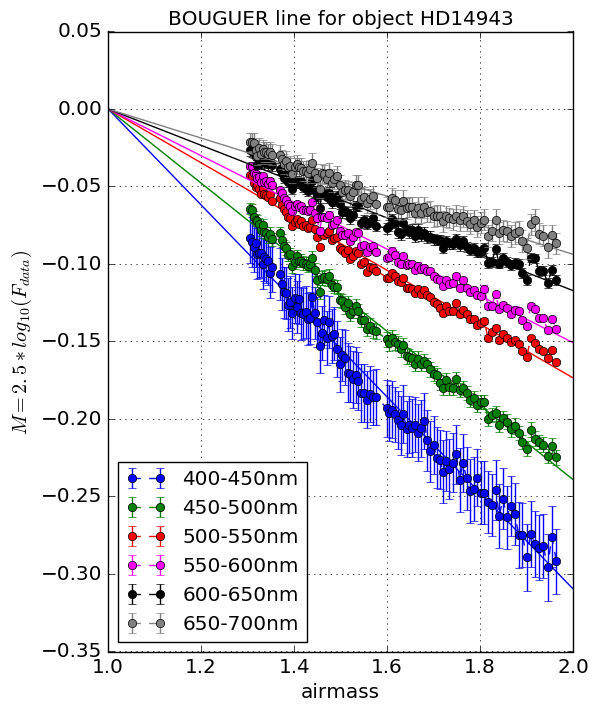

In [80]:
fitparamtruebouguer,popt_truebouguer,perr_truebouguer = ShowTrueBouguer(all_selected_wl,all_selected_dataspectrum,all_airmass)

In [81]:
truncpopt_truebouguer=np.trunc(np.array(popt_truebouguer)*10000)/10000
truncperr_truebouguer=np.trunc(np.array(perr_truebouguer)*10000)/10000

In [82]:
table = ListTable()
table.append(["slope","error"])
for idd in range(0,6):
    table.append([truncpopt_truebouguer[idd][0],truncperr_truebouguer[idd][0]])
table

[['slope', 'error'],
 [-0.31280000000000002, 0.0038],
 [-0.24099999999999999, 0.0022000000000000001],
 [-0.1759, 0.0023],
 [-0.14979999999999999, 0.0020999999999999999],
 [-0.1148, 0.0023],
 [-0.094600000000000004, 0.0022000000000000001]]

In [83]:
np.array(popt_truebouguer)[:,0]

array([-0.31280321, -0.24107533, -0.17596527, -0.14982067, -0.11482144,
       -0.09464404])

In [84]:
def FuncRayleigh(x,a):
    return a*(400/x)**4/(1-0.0752*(400./x)**2)

In [85]:
def PlotRayleigh(thepopt,theperr):
    X= [425.,475.,525.,575.,625.,675.]
    Y= np.array(thepopt)[:,0]
    EY=np.array(theperr)[:,0]*10
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(X,Y,yerr=EY,fmt='o',color='red')
    
    title="Slope of BOUGUER line vs wavelength for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("slope/airmass (mag)")
    ax.grid(True)
    
    
    popt, pcov = curve_fit(FuncRayleigh,X,Y,sigma=EY)
    perr = np.sqrt(np.diag(pcov))
    xfit=np.linspace(400.,700.0,50)
    yfit=FuncRayleigh(xfit,popt[0])
    plt.plot(xfit,yfit)
    
    figfilename=os.path.join(dir_top_images,'fitrayleighwithbouguer.pdf')
    plt.savefig(figfilename)
    
    print popt[0] ,' at 400 nm'

-0.462528592974  at 400 nm


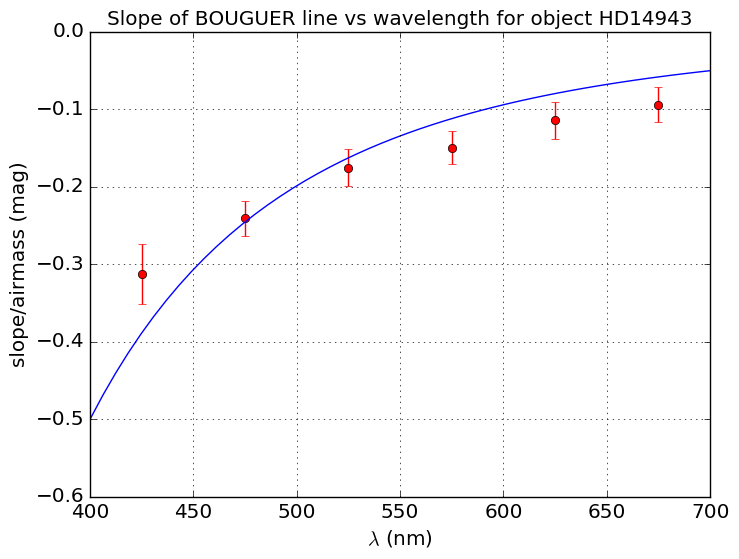

In [86]:
PlotRayleigh(popt_truebouguer,perr_truebouguer)

In [87]:
#all_airmass

In [88]:
index_airmassmin=1

In [89]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idx : the index of minimum airmass
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
    
    #XMIN=350.
    #XMAX=800.
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    
    
    
    #interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    interpol_ratio=interp1d(thewl[idx],ratio_sel0)
    
    #wlcutmax=all_rightspectra_wl[idx].max()-1.
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    #selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    selectedindexes0=np.where(np.logical_and(thewl[idx]>wlcutmin, thewl[idx]<wlcutmax))
    
    #sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    sel_wl0=thewl[idx][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idx]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        zam=all_airmass[index]
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        #selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        selectedindexes=np.where(np.logical_and(thewl[index]>wlcutmin, thewl[index]<wlcutmax))     
        
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=thewl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimRRatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam


### Return the ratio

minimum airmass zmin =  1.306


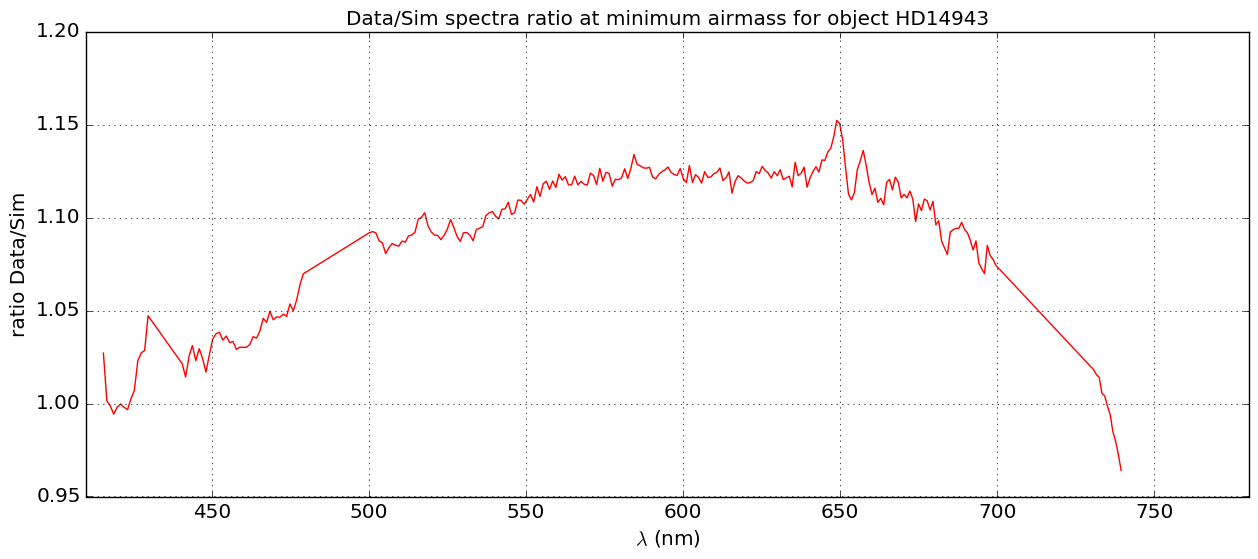

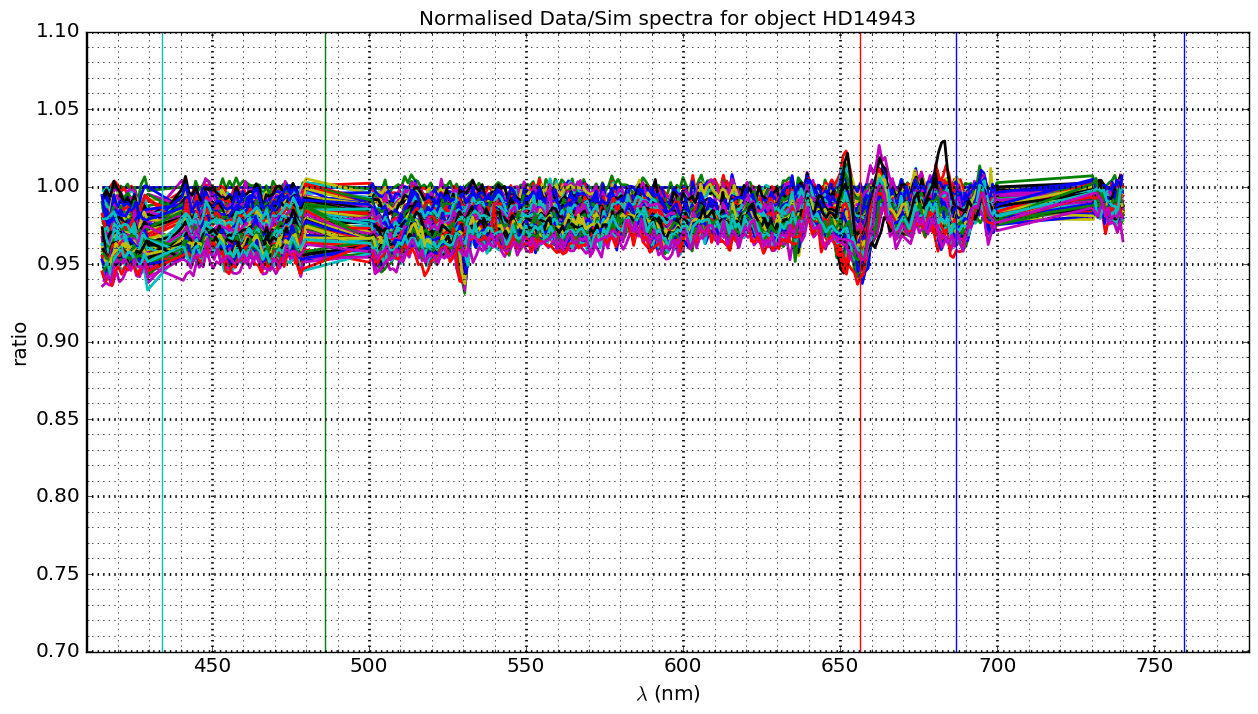

In [90]:
all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut=ShowRatioSpectraNorm(index_airmassmin,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [91]:
#all_ratiowl_full,all_ratioratio_full,all_dzam_full=ShowRatioSpectraNorm(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

## Bouguer Law

In [92]:
def ShowModifBouguer(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])  
    
    #ax.plot(all_z,all_log10R1vsZ,'o-',label=labels[0])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE1.pdf')
    plt.savefig(figfilename)
    

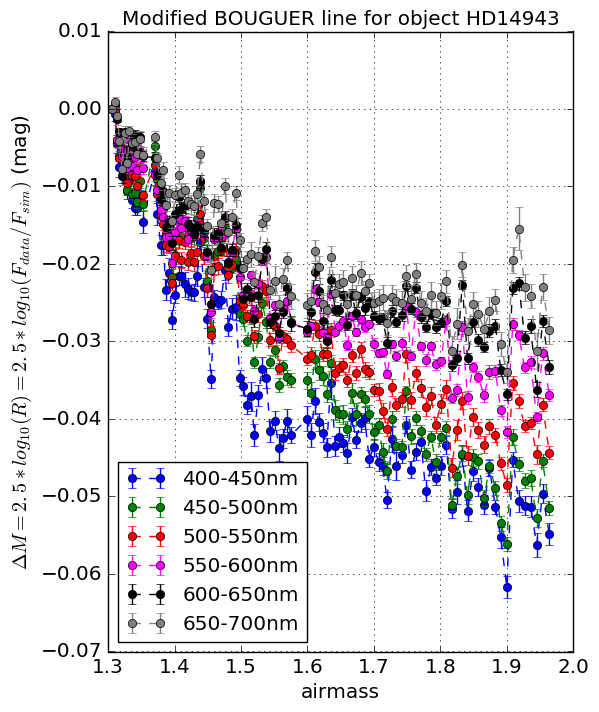

In [93]:
ShowModifBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [94]:
def ShowModifBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer2:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1))
            all_log10R2vsZE.append(np.std(all_log10R2))
            all_log10R3vsZE.append(np.std(all_log10R3))
            all_log10R4vsZE.append(np.std(all_log10R4))
            all_log10R5vsZE.append(np.std(all_log10R5))
            all_log10R6vsZE.append(np.std(all_log10R6))
        
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER curve for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE2.pdf')
    plt.savefig(figfilename)
    

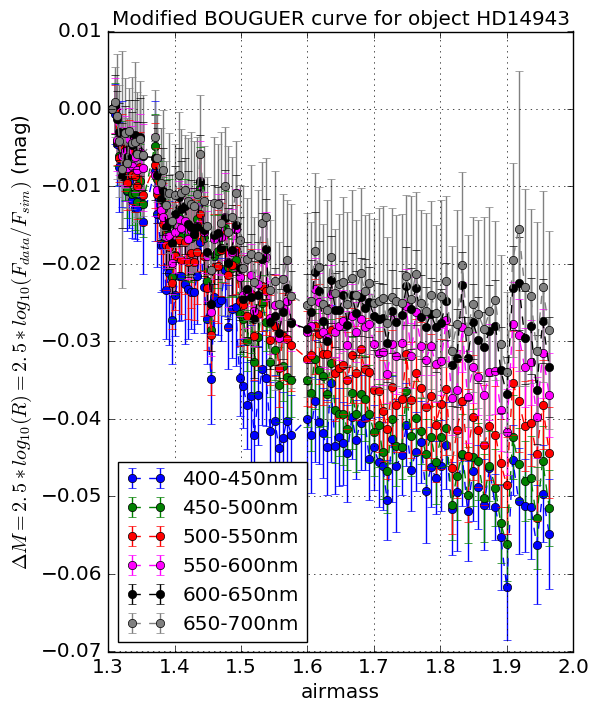

In [95]:
ShowModifBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [96]:
def SimpleLinearFitBouguer(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer:
    
    """
    
    ZCUT=1.5
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    fitparam1 = []
    fitparam2 = []
    y1fit = []
    y2fit = []
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    # loop on ratio
    #---------------
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
                
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
            
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
            
            if(thez<=ZCUT):  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
    
    
    x1=np.array(all_z1) 
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ1)
        elif iband ==1:
            y=np.array(all_log10R2vsZ1)
        elif iband==2:
            y=np.array(all_log10R3vsZ1)
        elif iband ==3:
            y=np.array(all_log10R4vsZ1) 
        elif iband==4:
            y=np.array(all_log10R5vsZ1)
        elif iband ==5:
            y=np.array(all_log10R6vsZ1) 
            
        z1 = np.polyfit(x1, y, 1)
        fitparam1.append(z1)    
        p1 = np.poly1d(z1)
        yfit=p1(x1fit)
        y1fit.append(yfit)
        
    x2=np.array(all_z2)
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ2)
        elif iband ==1:
            y=np.array(all_log10R2vsZ2)
        elif iband==2:
            y=np.array(all_log10R3vsZ2)
        elif iband ==3:
            y=np.array(all_log10R4vsZ2) 
        elif iband==4:
            y=np.array(all_log10R5vsZ2)
        elif iband ==5:
            y=np.array(all_log10R6vsZ2)            
        z2 = np.polyfit(x2, y, 1)
        fitparam2.append(z2)    
        p2 = np.poly1d(z2)
        yfit=p2(x2fit)
        y2fit.append(yfit)
                
    xfit=np.append(x1fit,x2fit)
    
    yfit=np.append(y1fit[0],y2fit[0])
    yfit=yfit-yfit[0] 
    ax.plot(xfit,yfit,'b-',lw=2,label=labels[0])
    
     
    yfit=np.append(y1fit[1],y2fit[1])
    yfit=yfit-yfit[1] 
    ax.plot(xfit,yfit,'r-',lw=2,label=labels[1])
    
    yfit=np.append(y1fit[2],y2fit[2])
    yfit=yfit-yfit[2] 
    ax.plot(xfit,yfit,'g-',lw=2,label=labels[2])
    
    yfit=np.append(y1fit[3],y2fit[3])
    yfit=yfit-yfit[3] 
    ax.plot(xfit,yfit,'k-',lw=2,label=labels[3])
    
    yfit=np.append(y1fit[4],y2fit[4])
    yfit=yfit-yfit[4] 
    ax.plot(xfit,yfit,'c-',lw=2,label=labels[4])
    
    yfit=np.append(y1fit[5],y2fit[5])
    yfit=yfit-yfit[5] 
    ax.plot(xfit,yfit,'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,np.append(y1fit[1],y2fit[1]),'r-',lw=2,label=labels[1])
    #ax.plot(xfit,np.append(y1fit[2],y2fit[2]),'g-',lw=2,label=labels[2])
    #ax.plot(xfit,np.append(y1fit[3],y2fit[3]),'k-',lw=2,label=labels[3])
    #ax.plot(xfit,np.append(y1fit[4],y2fit[4]),'c-',lw=2,label=labels[4])
    #ax.plot(xfit,np.append(y1fit[5],y2fit[5]),'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,y1fit[2],'g-',label=labels[2])
    #ax.plot(xfit,y1fit[3],'k-',label=labels[3])
    #ax.plot(xfit,y1fit[4],'c-',label=labels[4])
    #ax.plot(xfit,y1fit[5],'y-',label=labels[5])
    
    #ax.plot(x2fit,y2fit[0],'b-')
    #ax.plot(x2fit,y2fit[1],'r-')
    #ax.plot(x2fit,y2fit[2],'g-')
    #ax.plot(x2fit,y2fit[3],'k-')
    #ax.plot(x2fit,y2fit[4],'c-')
    #ax.plot(x2fit,y2fit[5],'y-')
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Simple Fit BOUGUER lines for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'fitbougher1.pdf')
    plt.savefig(figfilename)
    return np.array(fitparam1),np.array(fitparam2)
    

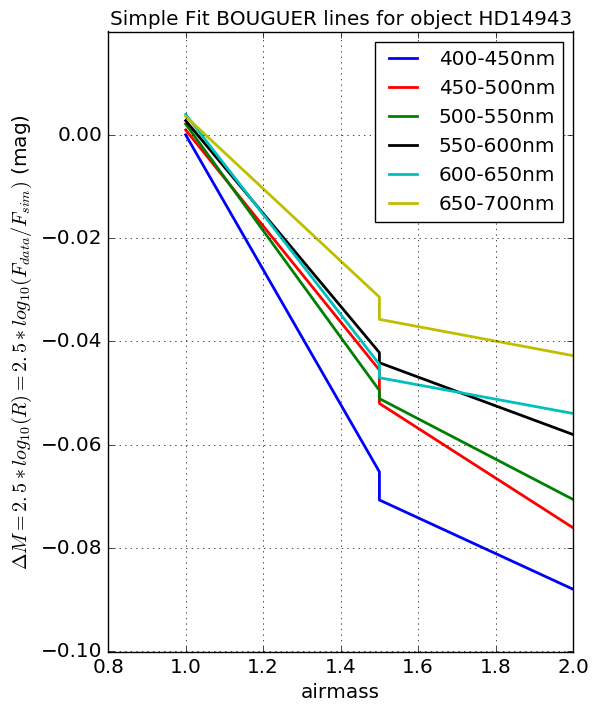

In [97]:
fitparam1_cut,fitparam2_cut=SimpleLinearFitBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

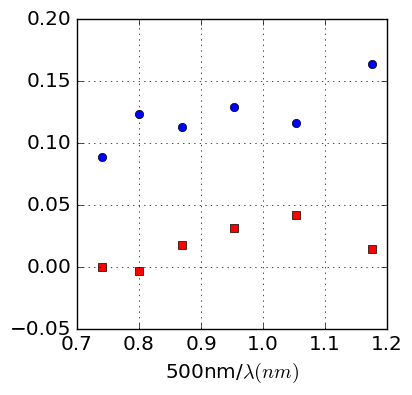

In [98]:
WLarr=np.array([425.,475.,525.,575.,625.,675.])
plt.plot(500/WLarr,fitparam1_cut[:,1] ,'o',color='blue')
plt.plot(500/WLarr,fitparam2_cut[:,1] ,'s',color='red')
plt.grid(True)
plt.xlabel("500nm/$\lambda (nm)$")

In [99]:
# import numpy.polynomial.polynomial.polyfit as polyfitw

In [100]:
from scipy.optimize import curve_fit

In [101]:
#def bougline(x, a, b):
#    return a*x + b

In [102]:
def FitABouguerLine(thex,they,theey):
    
    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theey)
    z = np.polyfit(x,y, 1)    
    popt, pcov = curve_fit(bougline,x,y,p0=z,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [103]:
def FitBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer2:
    
    """
    
    ZCUT=1.59
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_log10R1vsZ1E = []
    all_log10R2vsZ1E = []
    all_log10R3vsZ1E = []
    all_log10R4vsZ1E = []
    all_log10R5vsZ1E = []
    all_log10R6vsZ1E = []
    
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    all_log10R1vsZ2E = []
    all_log10R2vsZ2E = []
    all_log10R3vsZ2E = []
    all_log10R4vsZ2E = []
    all_log10R5vsZ2E = []
    all_log10R6vsZ2E = []
    
    fitparam1 = []
    fitparam2 = []
    
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    
    
    # loop on ratio to compute arerage and error points, that is to say, on the airmass z
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0: 
        
            thez=thedzam[index]+zmin
            
           
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
           
            # separate according the conditions depending on Z
            #--------------------------------------------------
            if thez<=ZCUT:  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
                
                all_log10R1vsZ1E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ1E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ1E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ1E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ1E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ1E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
                
                all_log10R1vsZ2E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ2E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ2E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ2E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ2E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ2E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
   
    
    # plot the points    
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='o',color='grey',label=labels[5])
    
    
    
    ## Now does the fit for z<ZCUT
    
    all_z1=np.array(all_z1)
    all_z2=np.array(all_z2)
    all_log10R1vsZ1=np.array(all_log10R1vsZ1)
    all_log10R2vsZ1=np.array(all_log10R2vsZ1)
    all_log10R3vsZ1=np.array(all_log10R3vsZ1)
    all_log10R4vsZ1=np.array(all_log10R4vsZ1)
    all_log10R5vsZ1=np.array(all_log10R5vsZ1)
    all_log10R6vsZ1=np.array(all_log10R6vsZ1)
    
    all_log10R1vsZ1E=np.array(all_log10R1vsZ1E)
    all_log10R2vsZ1E=np.array(all_log10R2vsZ1E)
    all_log10R3vsZ1E=np.array(all_log10R3vsZ1E)
    all_log10R4vsZ1E=np.array(all_log10R4vsZ1E)
    all_log10R5vsZ1E=np.array(all_log10R5vsZ1E)
    all_log10R6vsZ1E=np.array(all_log10R6vsZ1E)
    
    
    popt,perr=FitABouguerLine(all_z1,all_log10R1vsZ1,all_log10R1vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R2vsZ1,all_log10R2vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'g-',lw=2)
   
    
    popt,perr=FitABouguerLine(all_z1,all_log10R3vsZ1,all_log10R3vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R4vsZ1,all_log10R4vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R5vsZ1,all_log10R5vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R6vsZ1,all_log10R6vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'-',color='grey',lw=2)
        
    popt,perr=FitABouguerLine(all_z2,all_log10R1vsZ2,all_log10R1vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'b-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R2vsZ2,all_log10R2vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'g-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R3vsZ2,all_log10R3vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'r-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R4vsZ2,all_log10R4vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'m-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R5vsZ2,all_log10R5vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'k-',lw=2)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R6vsZ2,all_log10R6vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'-',color='grey',lw=2)
    
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="BOUGUER lines for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlim(1.3,2)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'fitbougherE1.pdf')
    plt.savefig(figfilename)
    

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/scipy/optimize/minpack.py:715: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


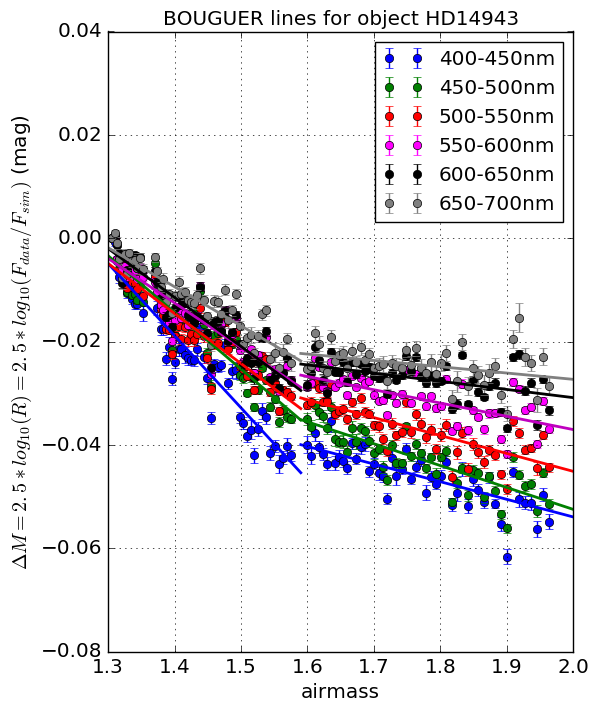

In [104]:
FitBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

## Fit Ratio

In [105]:
def FitRatio(all_ratiowl,all_ratioratio,all_dzam,figtitle='Normalised Data/Sim spectra for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=1.1
    YMIN=0.7
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dz=all_dzam[index]
        
        if all_expo[index]>0 and dz>0 : 
            x=all_ratiowl[index]
            y=all_ratioratio[index]
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
        
           
            ax.plot(xfit,yfit,'-',lw=1)
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitLinearDataSimNormDataSimRRatio.pdf')
    plt.savefig(figfilename)
    
    return np.array(fitparam)

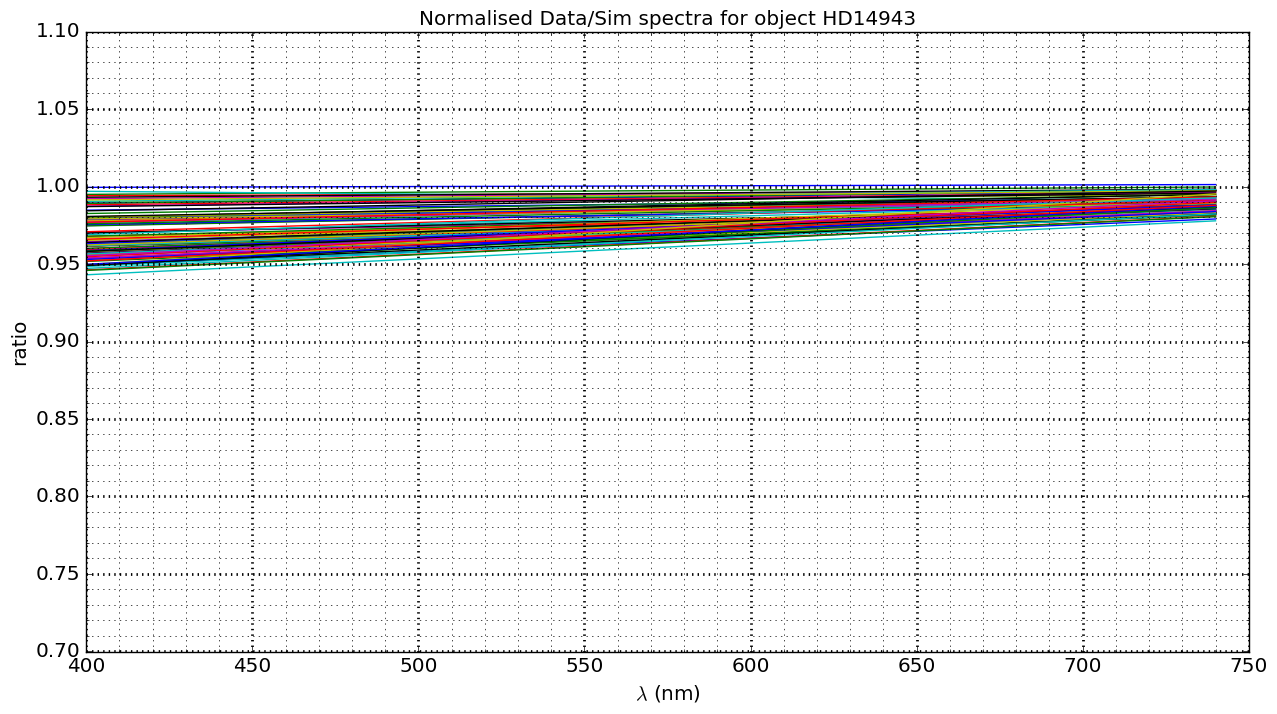

In [106]:
fitparam_cut=FitRatio(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [107]:
#fitparam_full=FitRatio(all_ratiowl_full,all_ratioratio_full,all_dzam_full)

## Definition of U ratio
=============================
$$
R(\lambda, z-z_{min}) = \frac{ \frac{T_{data}(z)}{T_{sim}(z)}}{ \frac{T_{data}(z_{min})}{T_{sim}(z_{min})}}= 
\exp \left( (z-z_{min}) \times \left(\tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha \right) \right)
$$


by calculating the following ratio $U(\lambda)$
$$
U(\lambda) = \frac{- \ln R(\lambda,z-z_{min})}{(z-z_{min})} = \tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha 
$$


From the series of images, we calculate $U(\lambda)$

In [108]:
def PlotExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'Extinction1_Uratio.pdf')
    plt.savefig(figfilename)
   

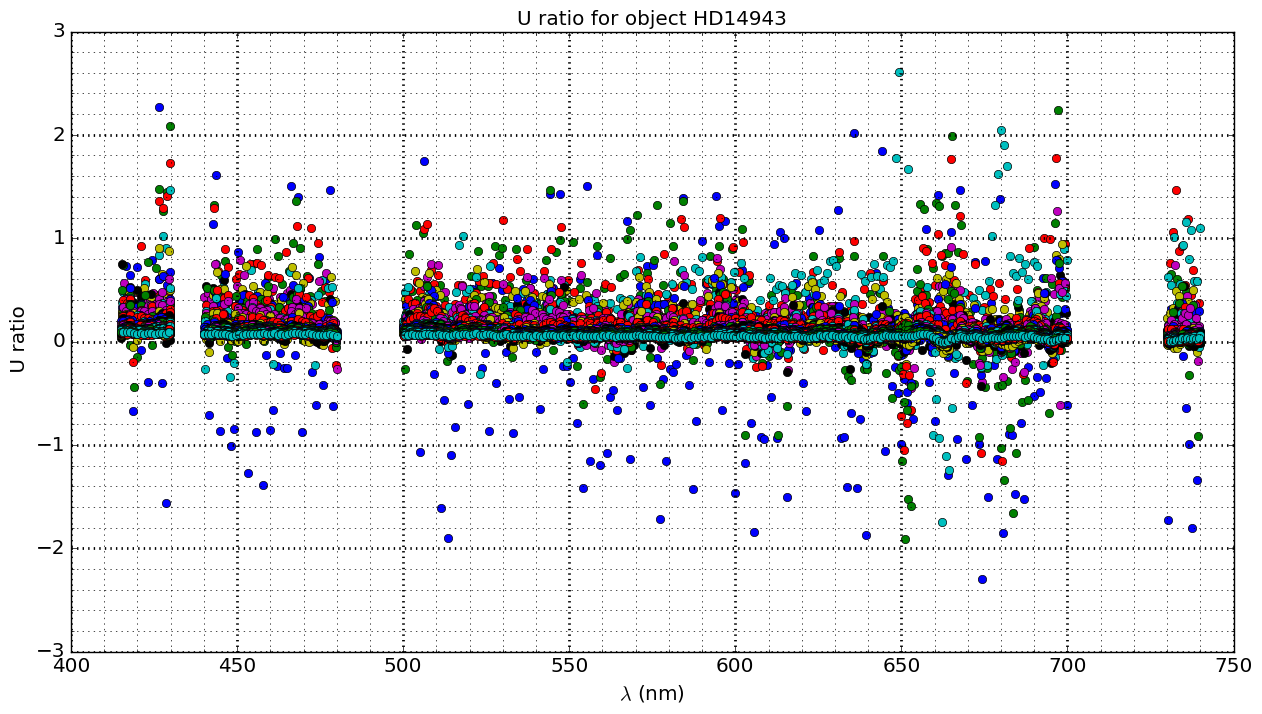

In [109]:
PlotExtinction1(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [110]:
#PlotExtinction1(all_ratiowl_full,all_ratioratio_full,all_dzam_full)

In [111]:
def PlotExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus 1/lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'Extinction2_Uratio.pdf')
    plt.savefig(figfilename)
    

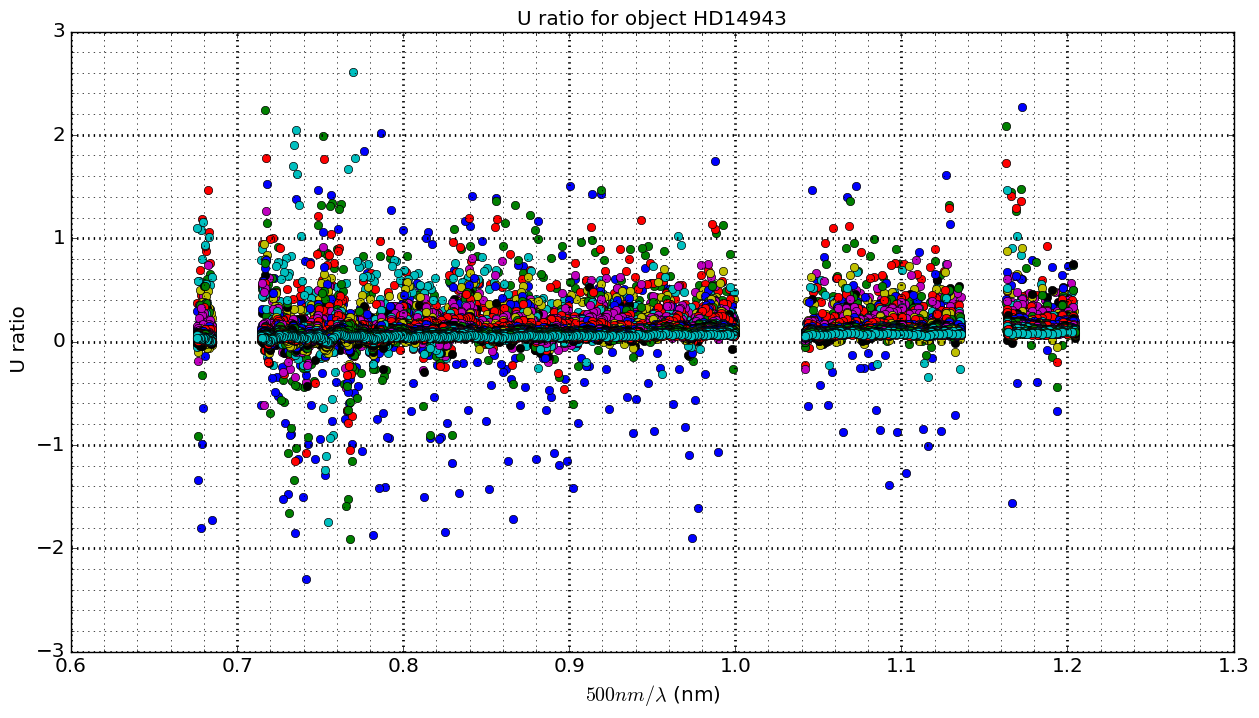

In [112]:
PlotExtinction2(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [113]:
#PlotExtinction2(all_ratiowl_full,all_ratioratio_full,all_dzam_full)

### Linear fit of extinction

In [114]:
def LinearFitExtinction(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit U ratio for object {}'):
   
    NBRATIOS=len(all_ratioratio)
    
    print "NBRATIOS =",NBRATIOS
    
    XMIN=0.65
    XMAX=1.3
    YMAX=1
    YMIN=-1

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIOS):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
                        
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
         
            ax.plot(xfit,yfit,'-',lw=1)        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'FitLinearExtinction2_Uratio.pdf')
    plt.savefig(figfilename)
    
        
    return np.array(fitparam), all_dzrel
        

NBRATIOS = 104


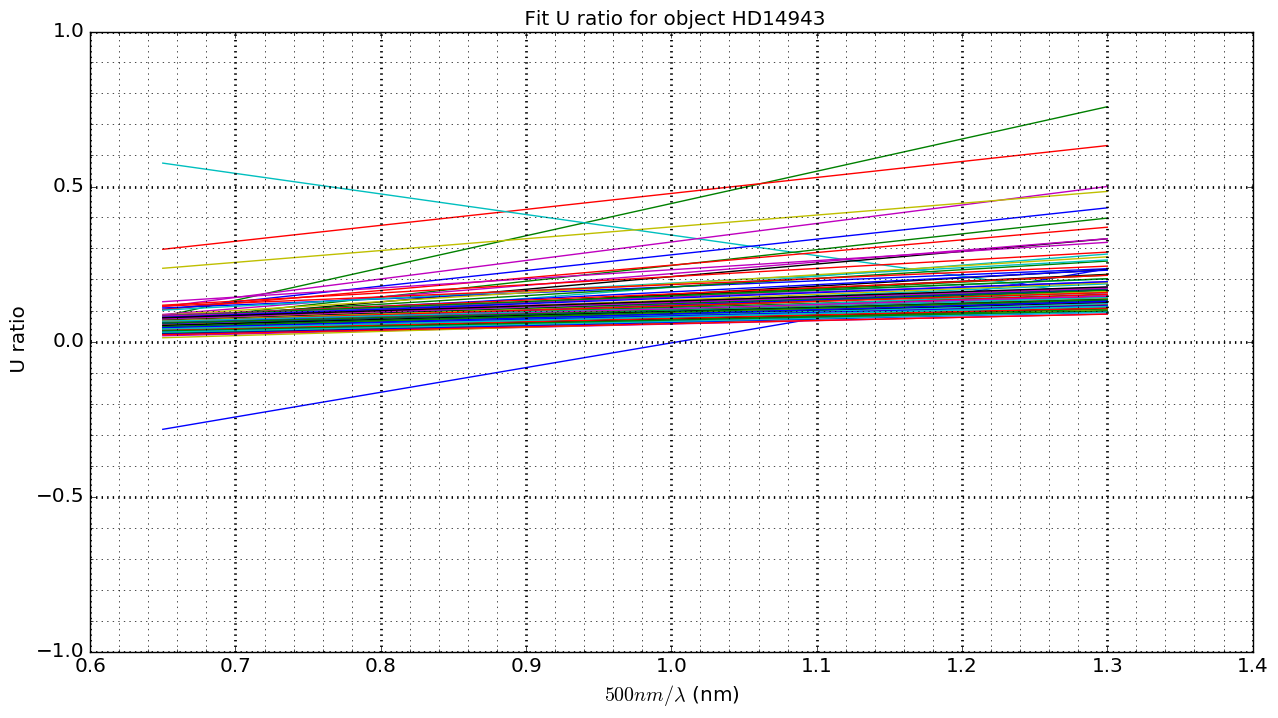

In [115]:
fitparam_cut,all_dzrel_cut=LinearFitExtinction(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [116]:
#fitparam_full,all_dzrel_full=LinearFitExtinction(all_ratiowl_full,all_ratioratio_full,all_dzam_full)

### Non linear fit of extinction

In [117]:
from scipy.optimize import curve_fit

In [118]:
def extinct(x, a, b,c):
    return a + b * x**c

In [119]:
def NonLinearFitExtinction(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit U ratio for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=0.65
    XMAX=1.3
    YMAX=0.5
    YMIN=-0.2

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitpcov= []
    fitchi2=[]
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            popt, pcov = curve_fit(extinct, x, y)
            chi2_vector=(y-extinct(x,popt[0],popt[1],popt[2]))**2
            chi2=np.average(chi2_vector)
            
            #print '------------------------------------'
            #print "a =", popt[0], "+/-", pcov[0,0]**0.5
            #print "b =", popt[1], "+/-", pcov[1,1]**0.5
            #print "c =", popt[2], "+/-", pcov[2,2]**0.5
            #print "chi2 =", chi2
                       
        
            fitoptparam.append(popt)  
            fitpcov.append(pcov)
            fitchi2.append(chi2)
            
            yfit=extinct(xfit,popt[0],popt[1],popt[2])
         
            if chi2 <0.01:
                ax.plot(xfit,yfit,'-',lw=1)        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Uratio.pdf')
    plt.savefig(figfilename)
   
        
    return np.array(fitoptparam), all_dzrel, fitpcov,fitchi2
        

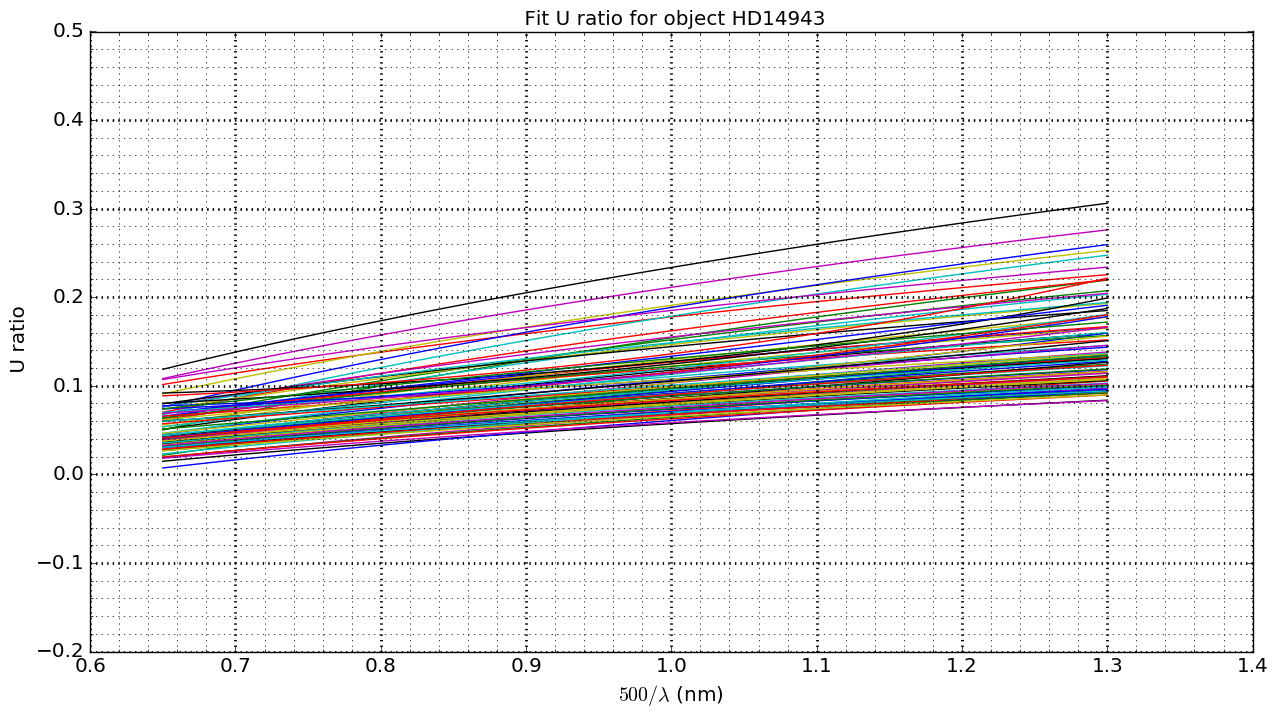

In [120]:
fitoptparam_cut,all_dzrel_cut,fitpcov_cut,fitchi2_cut=NonLinearFitExtinction(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [121]:
#fitoptparam_full,all_dzrel_full,fitpcov_full,fitchi2_full=NonLinearFitExtinction(all_ratiowl_full,all_ratioratio_full,all_dzam_full)

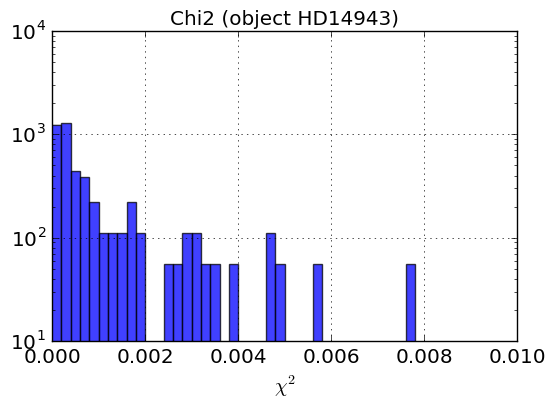

In [122]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

In [123]:
fitchi2_cut=np.array(fitchi2_cut)
select_good=np.where(fitchi2_cut<0.002)[0]

In [124]:
all_dzrel_cut=np.array(all_dzrel_cut)

In [125]:
fitoptparam_cut=np.array(fitoptparam_cut)

In [126]:
print select_good

[ 26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43
  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61
  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97
  98  99 100 101]


In [127]:
shiftdz=all_dzrel_cut[select_good]

In [128]:
def GetMeanAndSigma(arr):
    themean=np.mean(arr)
    thevariance=np.var(arr)
    thesigma=np.sqrt(thevariance)
    newmean=np.trunc(themean*1000)/1000
    newsigma=np.trunc(thesigma*1000)/1000
    #newmean=np.round(themean,3)
    #newsigma=np.round(thesigma,3)
    #newmean=np.rint(themean*1000)/1000
    #newsigma=np.rint(thesigma*1000)/1000
    thevariation=newsigma/newmean
    thevaria=np.trunc(thevariation*100)
    return newmean,newsigma,thevaria

### grey attenuation

In [129]:
GetMeanAndSigma(fitoptparam_cut[:,0])

(-1.175, 1.48, -125.0)

In [130]:
print "median = ",np.median(fitoptparam_cut[:,0])
print "average = ",np.average(fitoptparam_cut[:,0])
print "std = ",np.std(fitoptparam_cut[:,0])

median =  -0.984001015716
average =  -1.1758071992
std =  1.48068952714


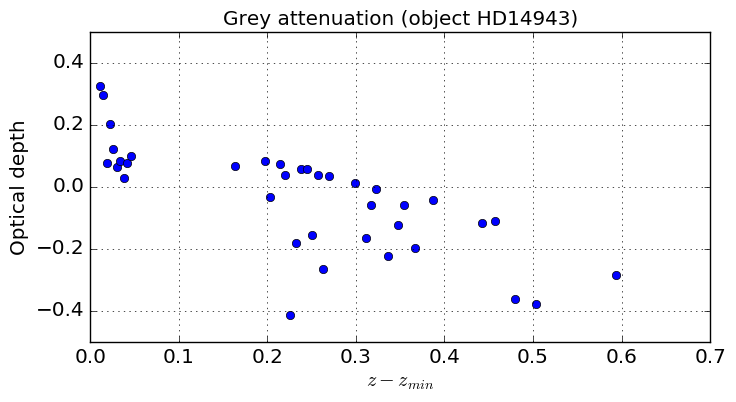

In [131]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut[:,0]
plt.plot(all_dzrel_cut,fitoptparam_cut[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz.pdf')
plt.savefig(figfilename)

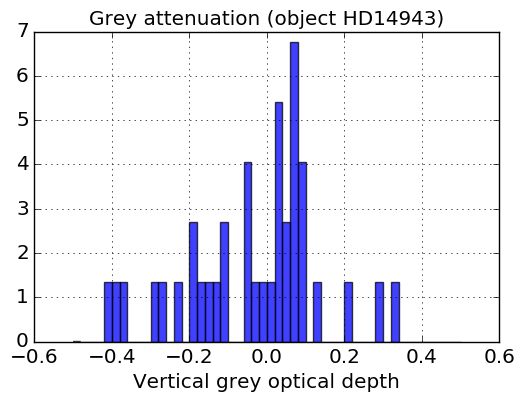

In [132]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto.pdf')
plt.savefig(figfilename)

### Aerosols  

In [133]:
GetMeanAndSigma(fitoptparam_cut[:,1])

(1.3, 1.492, 114.0)

In [134]:
print "median = ",np.median(fitoptparam_cut[:,1])
print "average = ",np.average(fitoptparam_cut[:,1])
print "std = ",np.std(fitoptparam_cut[:,1])

median =  1.06701863354
average =  1.30040179967
std =  1.49295747642


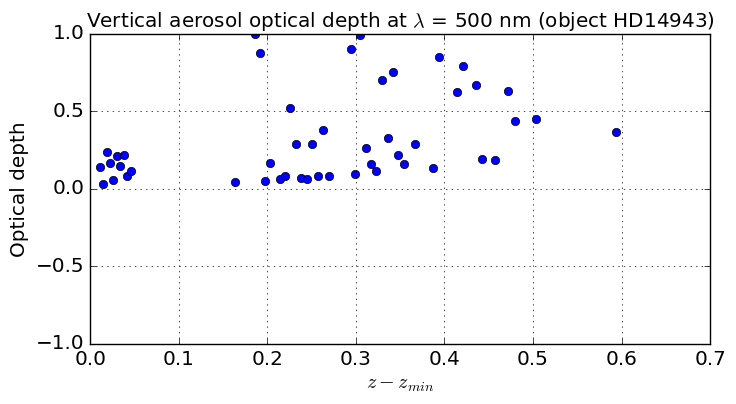

In [135]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut,fitoptparam_cut[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz.pdf')
plt.savefig(figfilename)

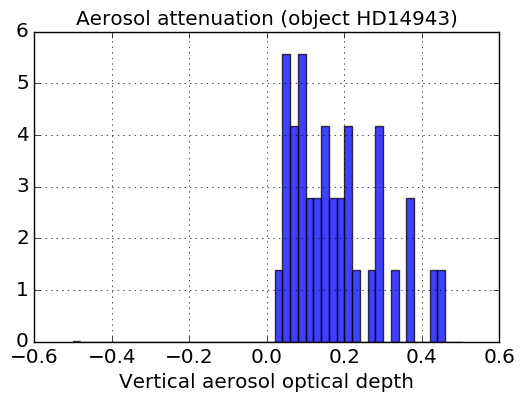

In [136]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto.pdf')
plt.savefig(figfilename)

### Angstrom exponent

In [137]:
GetMeanAndSigma(fitoptparam_cut[:,2])

(0.69199999999999995, 1.6559999999999999, 239.0)

In [138]:
print "median = ",np.median(fitoptparam_cut[:,2])
print "average = ",np.average(fitoptparam_cut[:,2])
print "std = ",np.std(fitoptparam_cut[:,2])

median =  0.107970820515
average =  0.692440249366
std =  1.65608443371


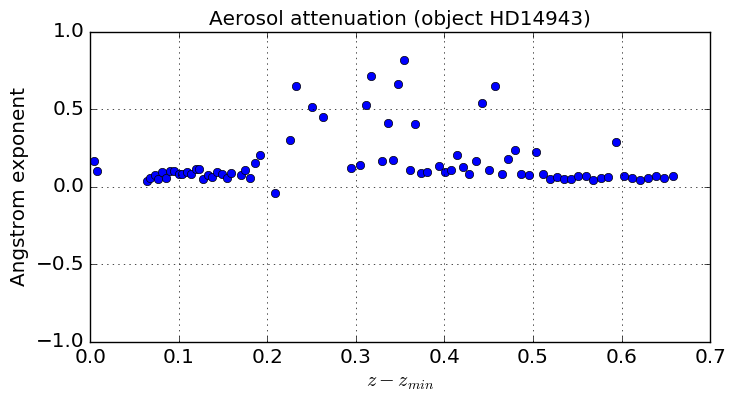

In [139]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut,fitoptparam_cut[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz.pdf')
plt.savefig(figfilename)

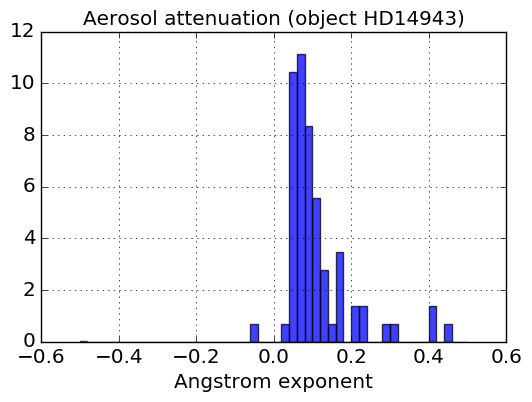

In [140]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto.pdf')
plt.savefig(figfilename)